In [64]:
# Core
import os
import importlib
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model / Feature selection / Scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Saving Model
import joblib


In [66]:
X_train = pd.read_csv('X_train.csv')
X_test  = pd.read_csv('X_test.csv')

y_train = pd.read_csv('Y_train.csv').squeeze("columns")  
y_test  = pd.read_csv('Y_test.csv').squeeze("columns")    # -> Series

# Optional sanity check
print(y_train.value_counts(dropna=False))
print(y_train.dtype)


Label
LumA      230
LumB      102
Normal     70
Basal      70
Her2       24
Name: count, dtype: int64
object


In [67]:
pipelineSvm = ImbPipeline([
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['linear'],
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter= 10,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=13,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.
{'svm__C': 0.1767016940294795, 'svm__kernel': 'linear'}


   mean_test_score  param_svm__C param_svm__kernel
0         0.764592      0.176702            linear
1         0.758368    506.157689            linear
2         0.758368     24.658329            linear
3         0.758368      3.907967            linear
7         0.758368    157.418900            linear
8         0.758368      4.042873            linear
9         0.758368     17.718847            linear
4         0.618146      0.008632            linear
5         0.618146      0.008629            linear
6         0.293834      0.002231            linear

Test Accuracy (best model): 0.8064516129032258

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.88      0.91        17
        Her2       0.71      0.71      0.71         7
        LumA       0.79      0.84      0.82        58
        LumB       0.75      0.60      0.67        25
      Normal       0.84      0.94      0.89        17

    accuracy                     

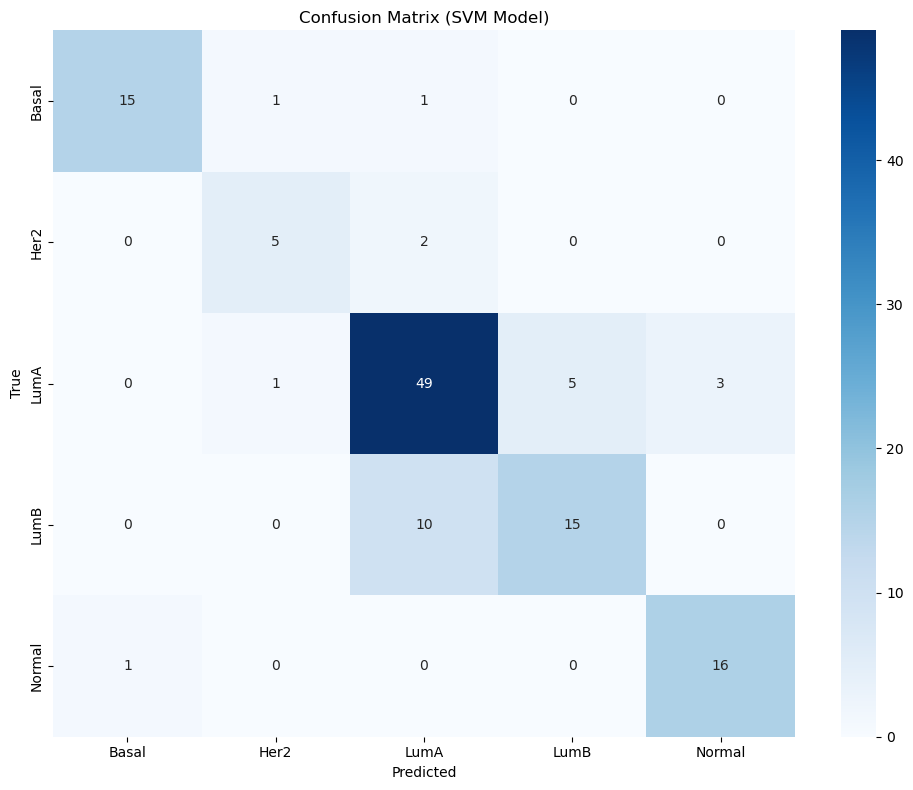

In [70]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__kernel']
print(top10[cols_to_show])

# Evaluate the model on test data
y_pred = best_model3.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


In [77]:
pipelineSvm = ImbPipeline([
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['rbf'],
    'svm__gamma': loguniform(1e-6, 1e-1)
    
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=20,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=13,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.
{'svm__C': 622.0025976819159, 'svm__gamma': 0.01101505679026964, 'svm__kernel': 'rbf'}


    mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
17         0.764241    622.002598          0.011015               rbf
1          0.764138     24.658329          0.000985               rbf
4          0.742734      4.042873          0.003470               rbf
12         0.615297      0.545029          0.008431               rbf
0          0.581667      0.176702          0.056698               rbf
19         0.561427     12.746712          0.000159               rbf
6          0.298087     98.777003          0.000012               rbf
7          0.293834      0.012330          0.000008               rbf
8          0.293834      0.066904          0.000421               rbf
9          0.293834      0.390544          0.000029               rbf

Test Accuracy (best model): 0.8225806451612904

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.71      0.71      0.

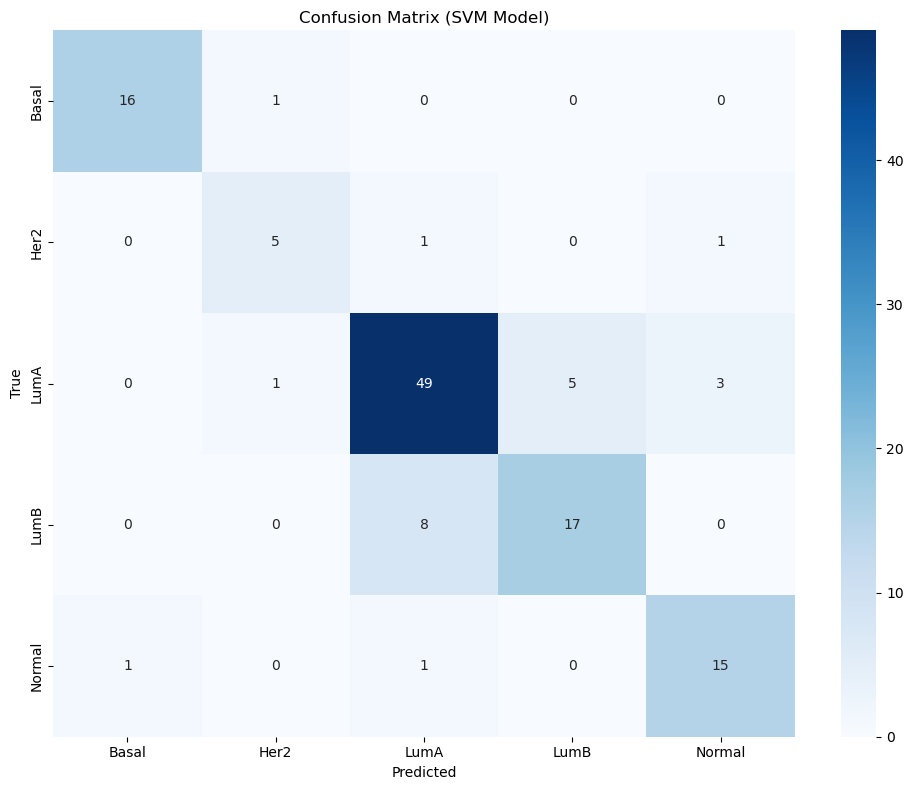

In [78]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel']
print(top10[cols_to_show])

# Evaluate the model on test data
y_pred = best_model3.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


In [119]:
pipelineSvm = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['linear'],
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=20,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.
{'svm__C': 0.008632008168602538, 'svm__kernel': 'linear'}


    mean_test_score  param_svm__C param_svm__kernel
4          0.782084      0.008632            linear
5          0.782084      0.008629            linear
19         0.781634      0.055895            linear
13         0.781149      0.018795            linear
16         0.777301      0.066904            linear
15         0.775122      0.012602            linear
14         0.775122      0.012330            linear
0          0.756586      0.176702            linear
8          0.749872      4.042873            linear
9          0.749872     17.718847            linear

Test Accuracy (best model): 0.7903225806451613

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.89      0.94      0.91        17
        Her2       0.67      0.86      0.75         7
        LumA       0.89      0.71      0.79        58
        LumB       0.59      0.76      0.67        25
      Normal       0.84      0.94      0.89        17

    accuracy          

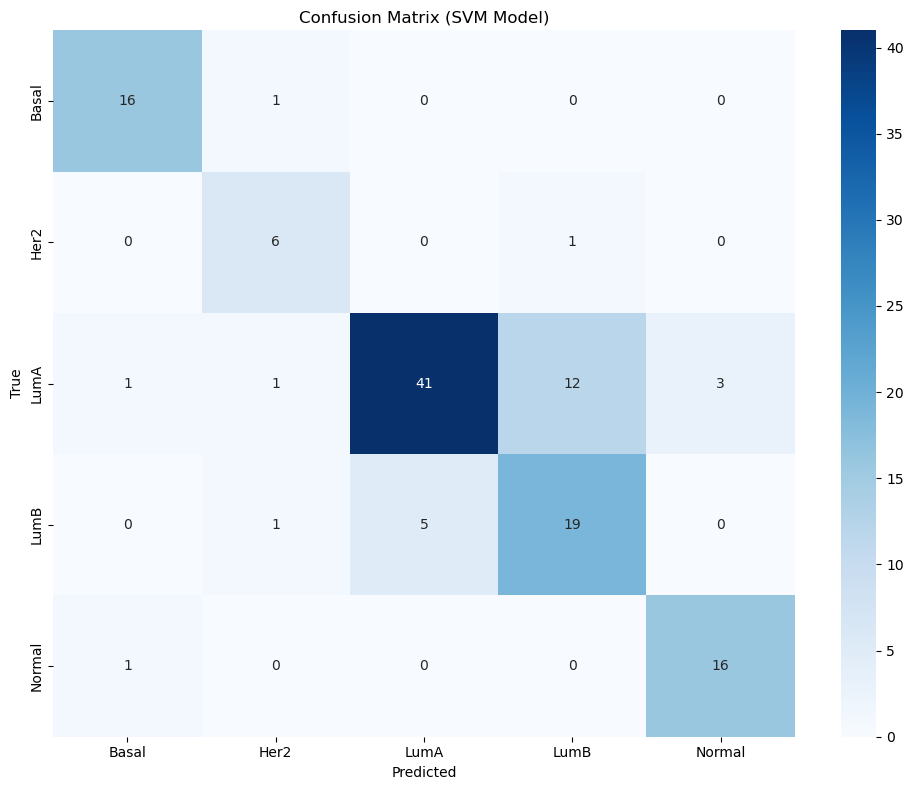

In [120]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__kernel']
print(top10[cols_to_show])

# Evaluate the model on test data
y_pred = best_model3.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


In [96]:
pipelineSvm = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['rbf'],
    'svm__gamma': loguniform(1e-6, 1e-1)
}


rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=20,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.
{'svm__C': 24.658329458549105, 'svm__gamma': 0.0009846738873614568, 'svm__kernel': 'rbf'}


    mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
1          0.777285     24.658329          0.000985               rbf
12         0.774672      0.545029          0.008431               rbf
4          0.766932      4.042873          0.003470               rbf
0          0.752760      0.176702          0.056698               rbf
17         0.752492    622.002598          0.011015               rbf
19         0.748474     12.746712          0.000159               rbf
6          0.716508     98.777003          0.000012               rbf
3          0.704041      0.002231          0.021423               rbf
16         0.696377      0.002456          0.055517               rbf
5          0.684788      0.001329          0.070721               rbf

Test Accuracy (best model): 0.8064516129032258

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.75      0.86      0.

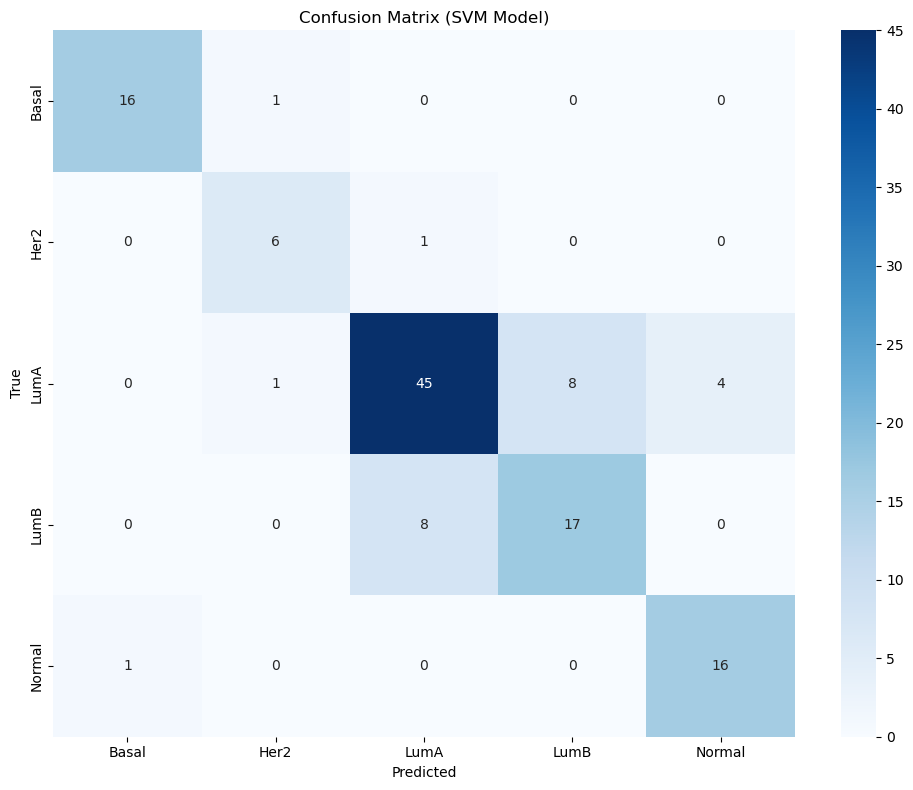

In [97]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel']
print(top10[cols_to_show])

# Evaluate the model on test data
y_pred = best_model3.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


In [110]:
pipelineSvm = ImbPipeline([
     ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['linear'],
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=10,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.
{'svm__C': 0.1767016940294795, 'svm__kernel': 'linear'}


   mean_test_score  param_svm__C param_svm__kernel
0         0.755237      0.176702            linear
1         0.749290    506.157689            linear
2         0.749290     24.658329            linear
3         0.749290      3.907967            linear
7         0.749290    157.418900            linear
8         0.749290      4.042873            linear
9         0.749290     17.718847            linear
4         0.721674      0.008632            linear
5         0.721674      0.008629            linear
6         0.489964      0.002231            linear

Test Accuracy (best model): 0.717741935483871

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.88      0.91        17
        Her2       0.67      0.57      0.62         7
        LumA       0.87      0.57      0.69        58
        LumB       0.50      0.84      0.63        25
      Normal       0.73      0.94      0.82        17

    accuracy                      

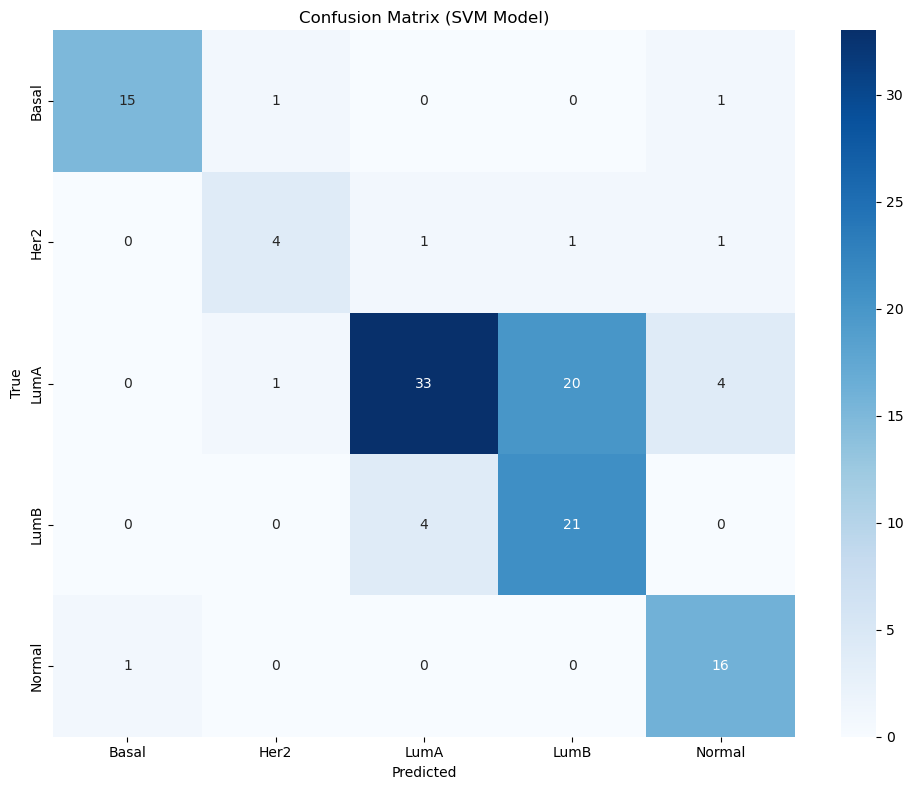

In [113]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__kernel']
print(top10[cols_to_show])

# Evaluate the model on test data
y_pred = best_model3.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


In [115]:
pipelineSvm = ImbPipeline([
     ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['rbf'],
    'svm__gamma': loguniform(1e-6, 1e-1)
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=10,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.
{'svm__C': 24.658329458549105, 'svm__gamma': 0.0009846738873614568, 'svm__kernel': 'rbf'}


   mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
1         0.763857     24.658329          0.000985               rbf
4         0.747729      4.042873          0.003470               rbf
0         0.696766      0.176702          0.056698               rbf
6         0.493688     98.777003          0.000012               rbf
2         0.293834      0.008632          0.000006               rbf
3         0.293834      0.002231          0.021423               rbf
5         0.293834      0.001329          0.070721               rbf
7         0.293834      0.012330          0.000008               rbf
8         0.293834      0.066904          0.000421               rbf
9         0.293834      0.390544          0.000029               rbf

Test Accuracy (best model): 0.7338709677419355

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.84      0.94      0.89        17
        Her2       0.80      0.57      0.67         

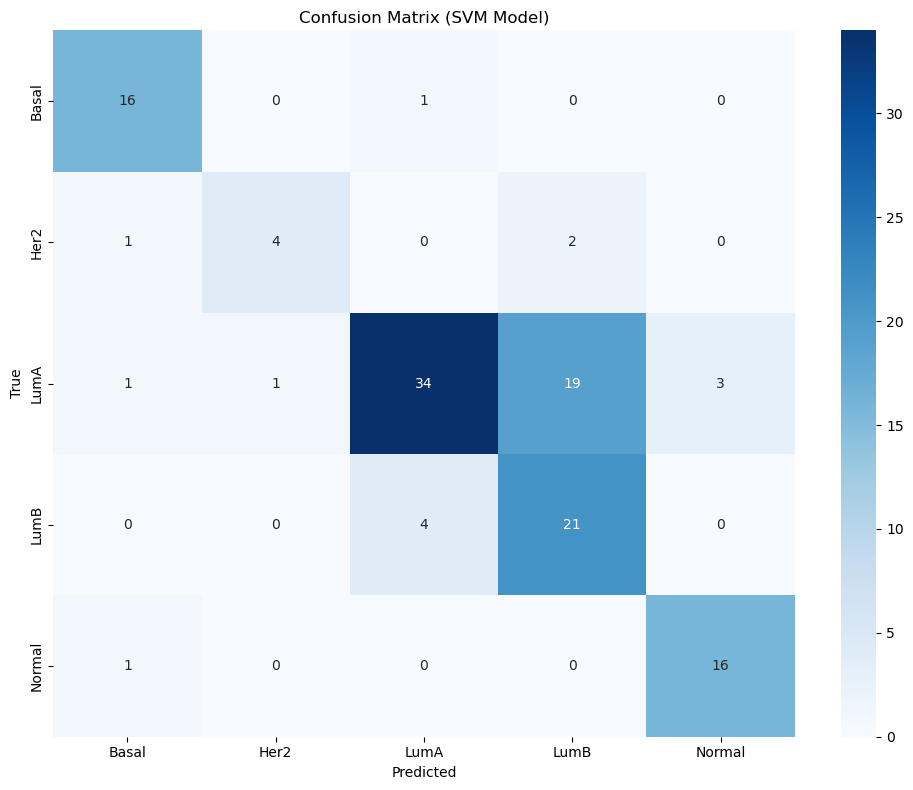

In [116]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel']
print(top10[cols_to_show])

# Evaluate the model on test data
y_pred = best_model3.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


In [ ]:
pipelineSvm = ImbPipeline([
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': loguniform(1e-6, 1e-1)
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=50,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=13,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_

